#### Importing Required Libraries

In [ ]:
pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.1 MB/s eta 0:00:00


In [ ]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

#### Importing dataset as a Pandas dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/CollabNotebooks/breast-cancer-wisconsin.data', sep=',', header=None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Setting column names

In [ ]:
column_names = [
    'Sample_code_number',
    'Clump_thickness',
    'Uniformity_of_cell_size',
    'Uniformity_of_cell_shape',
    'Marginal_adhesion',
    'Single_epithelial_cell_size',
    'Bare_nuclei',
    'Bland_chromatin',
    'Normal_nucleoli',
    'Mitoses',
    'Class'
]

data.columns = column_names

In [ ]:
data.head()

,Sample_code_number,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
data.shape

(699, 11)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample_code_number           699 non-null    int64 
 1   Clump_thickness              699 non-null    int64 
 2   Uniformity_of_cell_size      699 non-null    int64 
 3   Uniformity_of_cell_shape     699 non-null    int64 
 4   Marginal_adhesion            699 non-null    int64 
 5   Single_epithelial_cell_size  699 non-null    int64 
 6   Bare_nuclei                  699 non-null    object
 7   Bland_chromatin              699 non-null    int64 
 8   Normal_nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


##### NULL values are represented by '?'

In [ ]:
question_mark_locations = data.applymap(lambda x: x == '?')
print(question_mark_locations.sum())

Sample_code_number              0
Clump_thickness                 0
Uniformity_of_cell_size         0
Uniformity_of_cell_shape        0
Marginal_adhesion               0
Single_epithelial_cell_size     0
Bare_nuclei                    16
Bland_chromatin                 0
Normal_nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64


##### Replacing them with NaN and then dropping NULL values

In [ ]:
data = data.replace('?', np.nan)
data = data.dropna()

##### Dropping Sample_code_number (ID) column

In [ ]:
data = data.drop(['Sample_code_number'], axis=1)

##### Visualize Malign and Benign Patient Count

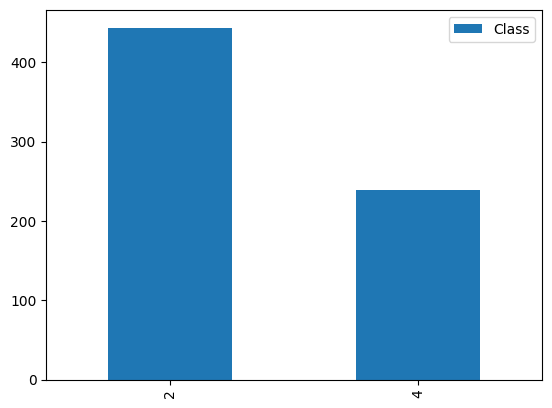

In [ ]:
count = data.Class.value_counts()
count.plot(kind='bar')
plt.legend()

##### In target variable Class 2 is benign, 4 is malignant categorsing them into 0 and 1

In [ ]:
data['Class'] = data['Class'].map(lambda x: 1 if x == 4 else 0)

#### Topic 1: Bayesian Network

In [ ]:
structure = [
    ('Clump_thickness', 'Uniformity_of_cell_size'),
    ('Uniformity_of_cell_size', 'Uniformity_of_cell_shape'),
    ('Uniformity_of_cell_size', 'Marginal_adhesion'),
    ('Marginal_adhesion', 'Single_epithelial_cell_size'),
    ('Single_epithelial_cell_size', 'Bare_nuclei'),
    ('Bare_nuclei', 'Bland_chromatin'),
    ('Bland_chromatin', 'Normal_nucleoli'),
    ('Normal_nucleoli', 'Mitoses'),
    ('Mitoses', 'Class'),
]

In [ ]:
bayesian_model = BayesianModel(structure)

##### Converting data back to a DataFrame for fitting the model

In [ ]:
X_train_df, X_test_df = train_test_split(data, test_size=0.2, random_state=0)

##### Model Fitting

In [ ]:
bayesian_model.fit(X_train_df, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=100, complete_samples_only=False)

##### Making predictions using Bayesian inference

In [ ]:
inference = VariableElimination(bayesian_model)
predicted_values = inference.map_query(variables=['Class'], evidence=dict(zip(X_test_df.columns[:-1], X_test_df.iloc[0, :-1])), show_progress=False)

##### Predicting Random Instances

In [ ]:
random_indices = random.sample(range(len(X_test_df)), 10)

for index in random_indices:
    actual_class = X_test_df.iloc[index]['Class']
    predicted_values = inference.map_query(variables=['Class'], evidence=dict(zip(X_test_df.columns[:-1], X_test_df.iloc[index, :-1])), show_progress=False)
    predicted_class = predicted_values['Class']
    print(f"Instance {index + 1}: Actual Class = {actual_class}, Predicted Class = {predicted_class}")

    if actual_class == predicted_class:
        print("Prediction is correct!\n")
    else:
        print("Prediction is incorrect.\n")

Instance 34: Actual Class = 0, Predicted Class = 0
Prediction is correct!

Instance 11: Actual Class = 1, Predicted Class = 1
Prediction is correct!

Instance 67: Actual Class = 0, Predicted Class = 0
Prediction is correct!

Instance 87: Actual Class = 0, Predicted Class = 0
Prediction is correct!

Instance 81: Actual Class = 1, Predicted Class = 1
Prediction is correct!

Instance 115: Actual Class = 0, Predicted Class = 0
Prediction is correct!

Instance 26: Actual Class = 1, Predicted Class = 1
Prediction is correct!

Instance 112: Actual Class = 0, Predicted Class = 0
Prediction is correct!

Instance 114: Actual Class = 1, Predicted Class = 0
Prediction is incorrect.

Instance 64: Actual Class = 0, Predicted Class = 0
Prediction is correct!



#### Topic 2: Decision Tree and Random Forest

##### Splitting the feature variables and target variable

In [ ]:
X = data.iloc[:,0:9]
y = data.iloc[:,-1]

##### Scaling the Feature variables

In [ ]:
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)

##### Test and train split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### Decision Tree Classifier

In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

##### Predictions

In [ ]:
y_pred_dt = dt_classifier.predict(X_test)

##### Accuracy for Decision Tree

In [ ]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")

Decision Tree Accuracy: 0.95


##### Confusion Matrix for Decision Tree

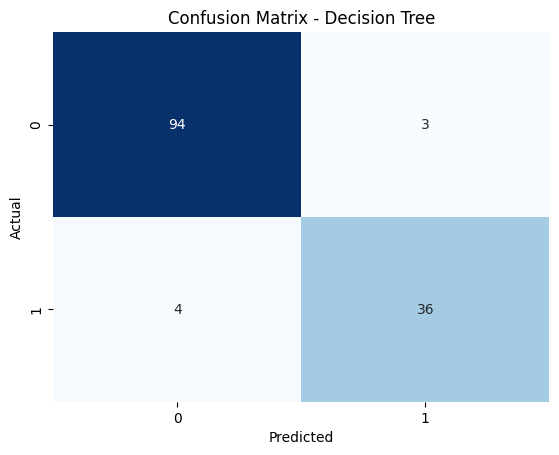

In [ ]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Random Forest Classifier

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

##### Predictions

In [ ]:
y_pred_rf = rf_classifier.predict(X_test)

##### Accuracy for Random Forest

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

Random Forest Accuracy: 0.96


##### Confusion Matrix for Random Forest

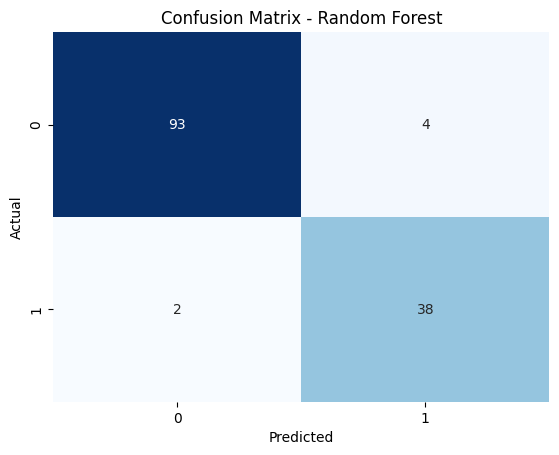

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()